In [20]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.nn import init
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import time
import PIL
from PIL import Image

to_pil = torchvision.transforms.ToPILImage()
n = 500

In [21]:
class Cfg:
    lr = 0.0001
    workers = 2
    batchSize = 2
    imageSize = 64
    n_epoch = 100
    beta1 = 0.5
    seed = 0
    cuda = True
    start_epo = 0
    pretrain = False
    nd_kpts = 6
cfg = Cfg()
device = torch.device("cpu")
print(device)
to_pil = torchvision.transforms.ToPILImage()

cpu


In [22]:
def load_data(n):
    X = []
    for i in range(n):
        try:
            img = Image.open(f"../images/screenshot_{i}.png")
        except:
            continue
        np_img = np.array(img)/255
        np_img = np.rollaxis(np_img, 2, 0)
        X.append(np_img)
    Y = np.load('../images/image_labels.npy')
    X = np.array(X)
    return X,Y

In [23]:
X,Y = load_data(n)
split = int(n-0.25*n)
Xt,Yt = X[:split,:,:,:],Y[:split,:,:]
Xv,Yv = X[split:,:,:,:],Y[split:,:,:]
Xt,Yt,Xv,Yv = torch.Tensor(Xt),torch.Tensor(Yt),torch.Tensor(Xv),torch.Tensor(Yv)

In [24]:
X.shape
Y.shape
print(Xv.shape)
print(Yv.shape)

torch.Size([3, 3, 512, 512])
torch.Size([3, 512, 512])


In [25]:
dataset = torch.utils.data.TensorDataset(Xt, Yt)
dataset_val = torch.utils.data.TensorDataset(Xv, Yv)

torch.Size([3, 512, 512])
torch.Size([512, 512])


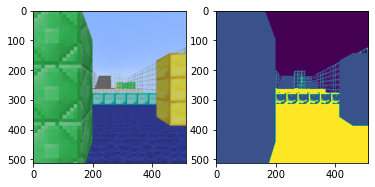

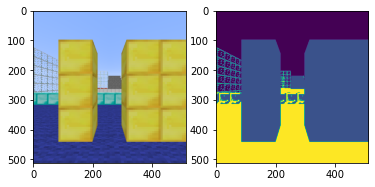

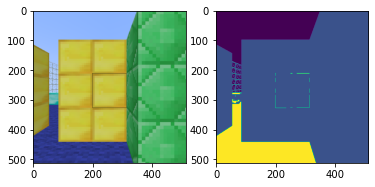

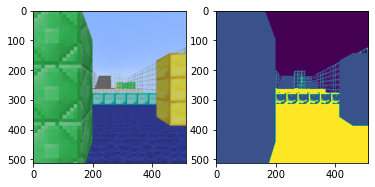

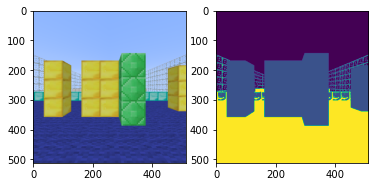

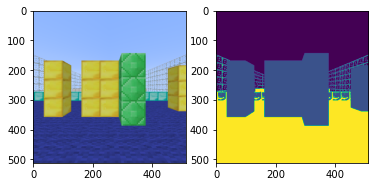

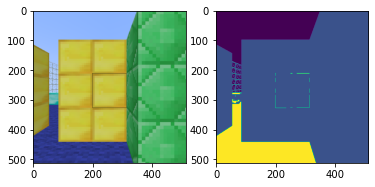

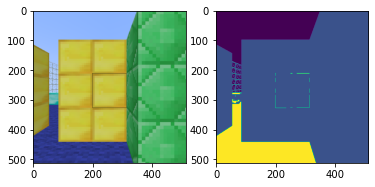

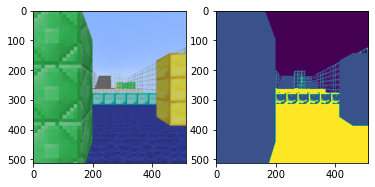

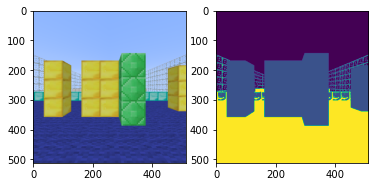

In [26]:
## NO NEED TO RUN THIS CELL IT JUST SHOWS U THE LABELS 
idx = np.random.choice(len(dataset), 10)
print(dataset[0][0].shape)
print(dataset[0][1].shape)
for i,j in enumerate(idx):
    _, axarr = plt.subplots(1, 2)
    img,label = dataset[j]
    temp = to_pil(img)
    axarr[0].imshow(temp)
    axarr[1].imshow(label, cmap='viridis',vmin=0, vmax=4)
    plt.show()

In [27]:
from torchvision.models.segmentation import segmentation
net = segmentation.deeplabv3_resnet50(num_classes=5).to(device)
net.train()
if cfg.pretrain:
    print("Weights Loaded")
    net.load_state_dict(torch.load("./saved_weights/vision_parameters.wts"))

In [28]:
optimizer = optim.Adam(net.parameters(), lr=cfg.lr)
criterion = nn.NLLLoss()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=cfg.batchSize,
                                         shuffle=True, num_workers=int(cfg.workers))
val_dataloader= torch.utils.data.DataLoader(dataset_val, batch_size=cfg.batchSize,
                                         shuffle=True, num_workers=int(cfg.workers))
sample_number = len(dataset)
val_number = len(dataset_val)
val_acc_list = []
val_loss_list = []

4
torch.Size([2, 3, 512, 512])
Progress: 0


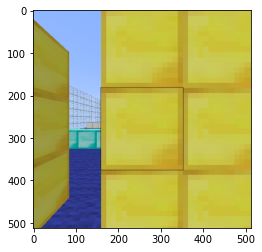

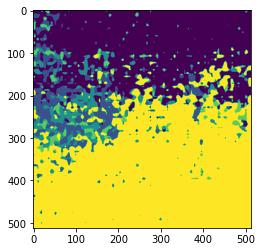

4
torch.Size([2, 3, 512, 512])


KeyboardInterrupt: 

In [29]:
for epoch in range(cfg.start_epo ,cfg.n_epoch):
    btime = time.time()
    train_loss = 0
    print(len(dataloader))
    for i, data in enumerate(dataloader):
        if i+1 >= len(val_dataloader):
            break;    
        net.zero_grad()
        images,labels = data
        print(images.size())
        images,labels  = images.to(device).float(),labels.to(device).long()
        outputs = net(images)['out']
        err = criterion(outputs, labels)
        err.backward()
        optimizer.step()
        train_loss += err.item()
        print("Progress:",i)
    train_loss_avg = train_loss/sample_number
    val_loss = 0
    acc = 0
    total = 0
    with torch.no_grad():
        val_loss = 0
        for i, data in enumerate(val_dataloader):
            if i+1 >= len(val_dataloader):
                break;                
            net.zero_grad()
            images,labels = data
            images,labels  = images.to(device).float(),labels.to(device).long()
            outputs = net(images)['out']
            am = torch.argmax(outputs[0],dim=0) == labels
            acc += torch.sum(am) 
            total += labels.shape[2]**2 *4
            err = criterion(outputs, labels)
            val_loss += err.item()
    temp_img = images[0].cpu().numpy()
    temp_img = np.rollaxis(temp_img, 0, 3)
    plt.imshow(temp_img)
    plt.show()
    plt.imshow(torch.argmax(outputs[0],dim=0).cpu().numpy())
    plt.show()
    
    val_loss_avg = val_loss/val_number
    val_acc_list.append((acc.item()/total))
val_loss_list.append(val_loss_avg)
print("Epoch =",epoch,"train_loss_avg =",train_loss_avg,"val_loss_avg =",val_loss_avg,"val acc =",(acc.item()/total))

In [ ]:
 torch.save(net.state_dict(),"./saved_weights/vision_parameters.wts")

In [ ]:
plt.plot(val_loss_list,label="loss")
plt.legend()
plt.savefig('loss.eps', format='eps')
plt.show()

In [ ]:
plt.plot(val_acc_list,label="acc")
plt.legend()
plt.savefig('acc.eps', format='eps')
plt.show()